# Model validation using ΔΔG
As an independent way of assessing explanations, use ΔΔG which indicates positions important for binding

For ΔΔG calculation of your pdb, you can visit: https://github.com/wells-wood-research/BAlaS or https://pragmaticproteindesign.bio.ed.ac.uk/balas/

In [7]:
import subprocess
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from tdc.multi_pred import PeptideMHC
from scipy import stats
from sklearn import metrics
import pickle, importlib
from collections import Counter
from scipy.stats.stats import pearsonr 
import seaborn as sns
import os 
import shap
import random
from scipy.spatial import distance
%matplotlib inline

In [5]:
df = pd.read_csv('./data/model_validation/pdb_df.csv','\t',index_col=0)

# Set alleles as per the predictors requirements
df['mhcflurry_allele'] = ['HLA-'+i for i in df['Allele']]
df['mhcfovea_allele'] = [i[0]+'*'+i[1:3]+':'+i[3:5] for i in df['Allele']]
df['transphla_allele'] = ['HLA-'+i for i in df['mhcfovea_allele']]
df['netmhcpan_allele'] = [i[:5]+i[6:] for i in df['transphla_allele']]
df

,Peptide_seq,Allele,PDB,Peptide_length,Resolution,mhcflurry_allele,mhcfovea_allele,transphla_allele,netmhcpan_allele
0,GRFAAAIAK,B2709,1k5n,9,1.09,HLA-B2709,B*27:09,HLA-B*27:09,HLA-B27:09
1,GLCTLVAML,A0201,3mre,9,1.10,HLA-A0201,A*02:01,HLA-A*02:01,HLA-A02:01
2,QATQEVKNW,B5301,7r7w,9,1.17,HLA-B5301,B*53:01,HLA-B*53:01,HLA-B53:01
3,RPQVPLRPM,B4201,4u1m,9,1.18,HLA-B4201,B*42:01,HLA-B*42:01,HLA-B42:01
4,RRRWHRWRL,B2709,3czf,9,1.20,HLA-B2709,B*27:09,HLA-B*27:09,HLA-B27:09
...,...,...,...,...,...,...,...,...,...
246,GAVDPLLAL,C0304,1efx,9,3.00,HLA-C0304,C*03:04,HLA-C*03:04,HLA-C03:04
247,IPSINVHHY,B3501,4qrr,9,3.00,HLA-B3501,B*35:01,HLA-B*35:01,HLA-B35:01
248,YLLMWITQV,A0201,4l29,9,3.09,HLA-A0201,A*02:01,HLA-A*02:01,HLA-A02:01
249,RLSSPLHFV,A0201,6ewc,9,3.20,HLA-A0201,A*02:01,HLA-A*02:01,HLA-A02:01


In [10]:
# Load pdbs list with ΔΔG calculations and create correlations with explanations

PDB_ls = os.listdir('./data/model_validation/BUDE/peptide/')

current_pd = df[df['PDB'].isin(PDB_ls)]

corr_shap_ls = []
corr_lime_ls = []

predictors = {'MHCflurry-PS':'mhcflurry_allele', 'MHCflurry-BA':'mhcflurry_allele',
              'MHCfovea':'mhcfovea_allele', 'TransPHLA':'transphla_allele', 
              'NetMHCpan-EL': 'netmhcpan_allele', 'NetMHCpan-BA': 'netmhcpan_allele'}

for predictor,v in predictors.items():
    print(predictor)
    corr_shap_ls_tmp = []
    corr_lime_ls_tmp = []
    for PDB in PDB_ls:
        pep = list(current_pd[current_pd['PDB'] == PDB]['Peptide_seq'])[0]
        DGG = list(pd.read_csv('./data/model_validation/BUDE/peptide/'+PDB,delimiter=r"\s+")['InterDDG'])
        
        hla = list(current_pd[current_pd['PDB'] == PDB][v])[0]
        shap_ls = np.load('./data/model_validation/results/SHAP/'+predictor+'/SHAP_'+pep+'_'+hla+'.npy')
        corr_shap_ls_tmp = corr_shap_ls_tmp + [np.corrcoef(np.array(DGG), shap_ls)[0][1]]

        lime_ls = np.load('./data/model_validation/results/LIME/'+predictor+'/LIME_'+pep+'_'+hla+'.npy')[1:10]
        corr_lime_ls_tmp = corr_lime_ls_tmp + [np.corrcoef(np.array(DGG), lime_ls)[0][1]]
        
    corr_shap_ls = corr_shap_ls + [corr_shap_ls_tmp]
    corr_lime_ls = corr_lime_ls + [corr_lime_ls_tmp]
    
pd.DataFrame(np.array(corr_shap_ls).transpose(),columns=predictors.keys()).to_csv('./data/model_validation/results/Pearr_validation_shap.csv')
pd.DataFrame(np.array(corr_lime_ls).transpose(),columns=predictors.keys()).to_csv('./data/model_validation/results/Pearr_validation_lime.csv')

MHCflurry-PS
MHCflurry-BA
MHCfovea
TransPHLA
NetMHCpan-EL
NetMHCpan-BA


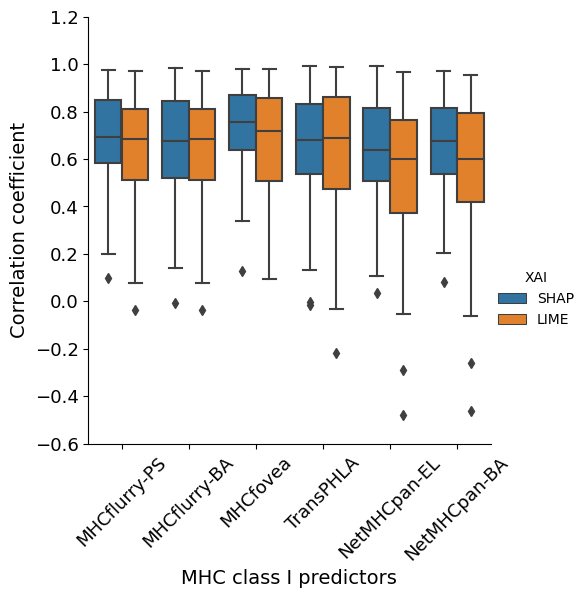

In [17]:
# Compare the correlations box plot
corr_shap_ls = pd.read_csv('./data/model_validation/results/Pearr_validation_shap.csv',index_col=0).melt()['value'].to_list()
corr_lime_ls = pd.read_csv('./data/model_validation/results/Pearr_validation_lime.csv',index_col=0).melt()['value'].to_list()

y = corr_shap_ls + corr_lime_ls
x = ['MHCflurry-PS']*len(PDB_ls)+['MHCflurry-BA']*len(PDB_ls)+\
    ['MHCfovea']*len(PDB_ls)+['TransPHLA']*len(PDB_ls)+\
    ['NetMHCpan-EL']*len(PDB_ls)+['NetMHCpan-BA']*len(PDB_ls)
x = x + x

hue = ['SHAP']*len(corr_shap_ls)+['LIME']*len(corr_lime_ls)

b = sns.catplot(data = pd.DataFrame({'y': y,
                                     'x': x,
                                     'XAI':hue}),
            x = 'x', y = 'y', hue='XAI',
            kind = 'box')

b.set_xlabels('MHC class I predictors',size=14)
b.set_ylabels('Correlation coefficient',size=14)
b.set_xticklabels(size=13, rotation=45)
b.set_yticklabels(size=13)


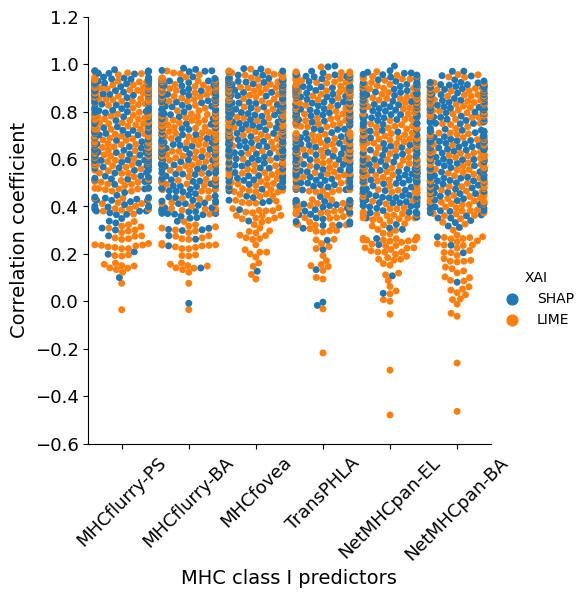

In [18]:
# Compare the correlations swarm plot
corr_shap_ls = pd.read_csv('./data/model_validation/results/Pearr_validation_shap.csv',index_col=0).melt()['value'].to_list()
corr_lime_ls = pd.read_csv('./data/model_validation/results/Pearr_validation_lime.csv',index_col=0).melt()['value'].to_list()

y = corr_shap_ls + corr_lime_ls
x = ['MHCflurry-PS']*len(PDB_ls)+['MHCflurry-BA']*len(PDB_ls)+\
    ['MHCfovea']*len(PDB_ls)+['TransPHLA']*len(PDB_ls)+\
    ['NetMHCpan-EL']*len(PDB_ls)+['NetMHCpan-BA']*len(PDB_ls)
x = x + x

hue = ['SHAP']*len(corr_shap_ls)+['LIME']*len(corr_lime_ls)

b = sns.catplot(data = pd.DataFrame({'y': y,
                                     'x': x,
                                     'XAI':hue}),
            x = 'x', y = 'y', hue='XAI',
            kind = 'swarm')

b.set_xlabels('MHC class I predictors',size=14)
b.set_ylabels('Correlation coefficient',size=14)
b.set_xticklabels(size=13, rotation=45)
b.set_yticklabels(size=13)
